In [25]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse

parser = argparse.ArgumentParser('ODE Test')
# See https://github.com/rtqichen/torchdiffeq/tree/master for all methods, especially fixed step
parser.add_argument('--method', type=str, choices=['adaptive_heun', 'bosh3', 'dopri5', 'dopri8', 'fehlberg2'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=26)
parser.add_argument('--iterations', type=int, default=1000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--adjoint', action='store_true', default=False)
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [26]:
def visualize(true_y: torch.Tensor, pred_y: torch.Tensor, learned_op):
    t_np = t.cpu().numpy()
    true_y_np = true_y.cpu().numpy()
    pred_y_np = pred_y.cpu().numpy()

    # Clear previous contents
    ax_traj.cla()
    ax_phase.cla()
    ax_vecfield.cla()

    # Trajectories
    ax_traj.set_title('Trajectory')
    ax_traj.set_xlabel('Time')
    ax_traj.set_ylabel('Position')
    ax_traj.plot(t_np, true_y_np[:, 0, 0], 'g-', label='True X')
    ax_traj.plot(t_np, true_y_np[:, 0, 1], 'g-', label='True Y')
    ax_traj.plot(t_np, pred_y_np[:, 0, 0], 'b--', label='Pred X')
    ax_traj.plot(t_np, pred_y_np[:, 0, 1], 'b--', label='Pred Y')
    ax_traj.set_xlim(t_np.min(), t_np.max())
    ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

    # Phase Spaces
    ax_phase.set_title('Phase Space')
    ax_phase.set_xlabel('Position')
    ax_phase.set_ylabel('Momentum')
    ax_phase.plot(true_y_np[:, 0, 0], true_y_np[:, 0, 1], 'g-')
    ax_phase.plot(pred_y_np[:, 0, 0], pred_y_np[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2, 2)
    ax_phase.set_ylim(-2, 2)

    # Vector Field
    ax_vecfield.set_title('Vector Field')
    ax_vecfield.set_xlabel('X')
    ax_vecfield.set_ylabel('Y')
    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = learned_op(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)


In [27]:
class HyperNetwork(nn.Module):
    """
    Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim: int, hidden_dim: int, width: int):
        super().__init__()

        blocksize = in_out_dim * width

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)
        U = params[self.blocksize:2*self.blocksize].reshape(self.width, 1, self.in_out_dim)
        G = params[2*self.blocksize:3*self.blocksize].reshape(self.width, 1, self.in_out_dim)
        B = params[3*self.blocksize:3*self.blocksize+self.width].reshape(self.width, 1, 1)
        return [W, U, G, B]

In [28]:
class ODEFunc(nn.Module):
    def __init__(self, in_out_dim: int = 2, hidden_dim: int = 35, width: int = 50):
        super(ODEFunc, self).__init__()
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, y):
        W, U, G, B = self.hyper_net(t)

        with torch.set_grad_enabled(True):
            y.requires_grad_(True)
            Y = torch.unsqueeze(y, 0) # 1 x batch_size x 1 x in_out_dim
            U = U * torch.sigmoid(G)

            h = torch.tanh(torch.matmul(Y, W.unsqueeze(-3))).mean(0) #  + B.unsqueeze(-3)
            print("hhhhhhhh", h.shape)

        return h

In [29]:
def get_batch() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    s = torch.from_numpy(
        np.random.choice(
            np.arange(args.data_size - args.batch_time, dtype=np.int64),
            args.batch_size,
            replace=False
        )
    )
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)
        
device = torch.device('cpu')
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., args.batch_size, args.data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method=args.method)


SIZES torch.Size([26, 1, 2]) torch.Size([10, 26, 1, 2]) torch.Size([10])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])
hhhhhhhh torch.Size([26, 1, 1])


RuntimeError: shape '[26, 1, 2]' is invalid for input of size 26

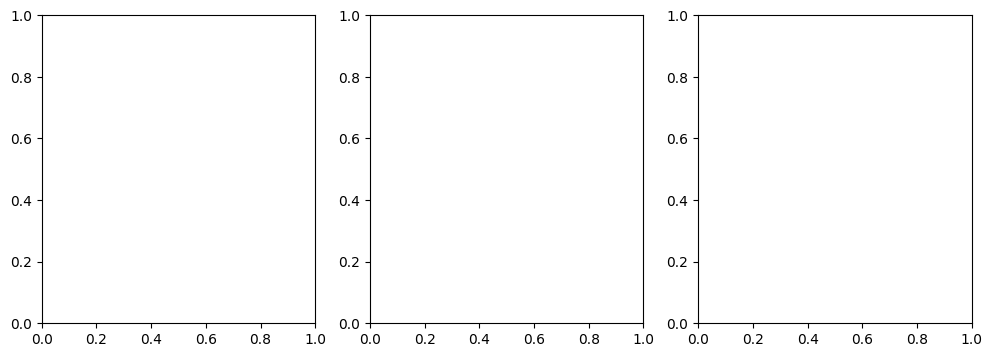

In [30]:


from matplotlib.animation import FuncAnimation
from functools import partial
from IPython.display import HTML

fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12, 4))
learned_op = ODEFunc().to(device)
optimizer = optim.RMSprop(learned_op.parameters(), lr=1e-3)

def train_loop(optimizer, true_y0, t):
    for itr in range(1, args.iterations + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        print("SIZES", batch_y0.size(), batch_y.size(), batch_t.size())
        pred_y = odeint(learned_op, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0:
            with torch.no_grad():
                test_pred_y = odeint(learned_op, true_y0, t)
                test_loss = torch.mean(torch.abs(test_pred_y - true_y))
                print(f'Total Loss {test_loss.item()}')
                yield true_y, test_pred_y

def viz_update(frame):
    true_y, pred_y = frame
    visualize(true_y, pred_y, learned_op)

if __name__ == '__main__':
    viz_frames = list(train_loop(optimizer, true_y0, t))

    ani = FuncAnimation(
        fig,
        viz_update,
        frames=viz_frames,
        repeat=False
    )
    html_animation = HTML(ani.to_jshtml())
    display(html_animation)
